# Fama-French 5 Factor model

In [1]:
# !pip install pandas_ta
# !pip install --upgrade numpy pandas_ta

In [11]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf


## Data Processing

In [12]:
# sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

# symbols_list = sp500['Symbol'].unique().tolist()
# symbols_list.append('^GSPC')
# start_date = '2024-04-01'
end_date = '2024-12-31'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*10)

df = yf.download(tickers=['NVDA','^GSPC'],
                 start=start_date,
                 end=end_date,auto_adjust =False,threads=True).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()
df.head()

[*********************100%***********************]  2 of 2 completed


Price                adj close        close         high          low  \
date       ticker                                                       
2015-01-05 NVDA       0.474939     0.494750     0.504750     0.492500   
           ^GSPC   2020.579956  2020.579956  2054.439941  2017.339966   
2015-01-06 NVDA       0.460540     0.479750     0.496000     0.479250   
           ^GSPC   2002.609985  2002.609985  2030.250000  1992.439941   
2015-01-07 NVDA       0.459340     0.478500     0.487500     0.477000   

Price                     open      volume  
date       ticker                           
2015-01-05 NVDA       0.503250   197952000  
           ^GSPC   2054.439941  3799120000  
2015-01-06 NVDA       0.495500   197764000  
           ^GSPC   2022.150024  4460110000  
2015-01-07 NVDA       0.483250   321808000

In [13]:
# Risk-free rate (10-year U.S. Treasury yield as a percentage, e.g., 4.305%)
risk_free_rate = 0.04035/252  # Convert annual rate to daily rate
risk_free_rate

0.0001601190476190476

In [29]:
df2 = df.reset_index()[['date', 'ticker', 'close']]
df2.head()
df2 = df2[(df2['ticker'] == 'NVDA') | (df2['ticker'] == '^GSPC') ]
df2.head()

Price,date,ticker,close
0,2015-01-05,NVDA,0.494750
1,2015-01-05,^GSPC,2020.579956
2,2015-01-06,NVDA,0.479750
3,2015-01-06,^GSPC,2002.609985
4,2015-01-07,NVDA,0.478500


In [30]:
Stock_close = df2.pivot(index = 'date', columns = 'ticker',values = 'close')
Stock_close = Stock_close.pct_change().dropna()
Stock_close = Stock_close.rename(columns={'^GSPC': 'GSPC'})
Stock_close = Stock_close.reset_index()
Stock_close_capm = Stock_close
Stock_close.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2513 non-null   datetime64[ns]
 1   NVDA    2513 non-null   float64       
 2   GSPC    2513 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 59.0 KB


In [31]:
Stock_close_capm['exs_rtn_nvda'] = Stock_close_capm['NVDA'] -risk_free_rate

Stock_close_capm['MKT_prm'] = Stock_close_capm['GSPC'] -risk_free_rate
Stock_close_capm = Stock_close_capm[['date','exs_rtn_nvda','MKT_prm']]
Stock_close_capm.head()


ticker,date,exs_rtn_nvda,MKT_prm
0,2015-01-06,-0.030478,-0.009054
1,2015-01-07,-0.002766,0.011470
2,2015-01-08,0.037457,0.017728
3,2015-01-09,0.003868,-0.008564
4,2015-01-12,-0.012698,-0.008254


In [32]:
Stock_close_capm = Stock_close_capm.set_index('date')
Stock_close_capm.info()
Stock_close_capm.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2513 entries, 2015-01-06 to 2024-12-30
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   exs_rtn_nvda  2513 non-null   float64
 1   MKT_prm       2513 non-null   float64
dtypes: float64(2)
memory usage: 58.9 KB


ticker,exs_rtn_nvda,MKT_prm
date,,
2015-01-06,-0.030478,-0.009054
2015-01-07,-0.002766,0.011470
2015-01-08,0.037457,0.017728
2015-01-09,0.003868,-0.008564
2015-01-12,-0.012698,-0.008254


In [33]:
# 5 Factor Fama french model
url = 'https://github.com/Amanjhagta/Data-Science/blob/main/Data/fama-french/F-F_Research_Data_5_Factors_2x3_daily.CSV?raw=True'
factor_data = pd.read_csv(url)
factor_data['date'] = pd.to_datetime(factor_data['date'], format='%Y%m%d')
factor_data.head()

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012
1,1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012
2,1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012
3,1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012
4,1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012


In [19]:
Stock_close_FF = pd.merge(Stock_close, factor_data, on="date", how="left")
Stock_close_FF['exs_rtn_nvda'] = Stock_close_FF['NVDA'] - Stock_close_FF['RF']
Stock_close_FF = Stock_close_FF.rename(columns={'Mkt-RF': 'MKT_prmf'})
Stock_close_FF.head()

,date,NVDA,GSPC,exs_rtn_nvda,MKT_prm,MKT_prmf,SMB,HML,RMW,CMA,RF
0,2015-01-06,-0.030318,-0.008893,-0.030318,-0.009054,-1.04,-0.78,-0.31,0.53,0.02,0.0
1,2015-01-07,-0.002606,0.011630,-0.002606,0.011470,1.19,0.17,-0.66,0.25,-0.14,0.0
2,2015-01-08,0.037618,0.017888,0.037618,0.017728,1.81,-0.10,-0.28,0.11,-0.16,0.0
3,2015-01-09,0.004028,-0.008404,0.004028,-0.008564,-0.85,-0.02,-0.47,-0.12,-0.16,0.0
4,2015-01-12,-0.012538,-0.008094,-0.012538,-0.008254,-0.79,0.35,-0.45,0.15,0.17,0.0


In [20]:
Stock_close_FF_fltr = Stock_close_FF[['date','exs_rtn_nvda','MKT_prm','SMB','HML','RMW','CMA']]
# Stock_close_FF_fltr = Stock_close_FF_fltr.rename(columns={'Mkt-RF': 'MKT_prm'})
Stock_close_FF_fltr.head()

,date,exs_rtn_nvda,MKT_prm,SMB,HML,RMW,CMA
0,2015-01-06,-0.030318,-0.009054,-0.78,-0.31,0.53,0.02
1,2015-01-07,-0.002606,0.011470,0.17,-0.66,0.25,-0.14
2,2015-01-08,0.037618,0.017728,-0.10,-0.28,0.11,-0.16
3,2015-01-09,0.004028,-0.008564,-0.02,-0.47,-0.12,-0.16
4,2015-01-12,-0.012538,-0.008254,0.35,-0.45,0.15,0.17


In [21]:
Stock_close_FF_fltr = Stock_close_FF_fltr.set_index('date')
Stock_close_FF_fltr.head()

,exs_rtn_nvda,MKT_prm,SMB,HML,RMW,CMA
date,,,,,,
2015-01-06,-0.030318,-0.009054,-0.78,-0.31,0.53,0.02
2015-01-07,-0.002606,0.011470,0.17,-0.66,0.25,-0.14
2015-01-08,0.037618,0.017728,-0.10,-0.28,0.11,-0.16
2015-01-09,0.004028,-0.008564,-0.02,-0.47,-0.12,-0.16
2015-01-12,-0.012538,-0.008254,0.35,-0.45,0.15,0.17


In [22]:
Stock_close_FF_fltr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2513 entries, 2015-01-06 to 2024-12-30
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   exs_rtn_nvda  2513 non-null   float64
 1   MKT_prm       2513 non-null   float64
 2   SMB           2513 non-null   float64
 3   HML           2513 non-null   float64
 4   RMW           2513 non-null   float64
 5   CMA           2513 non-null   float64
dtypes: float64(6)
memory usage: 137.4 KB


In [ ]:
 Stock_close_FF_fltr.describe()

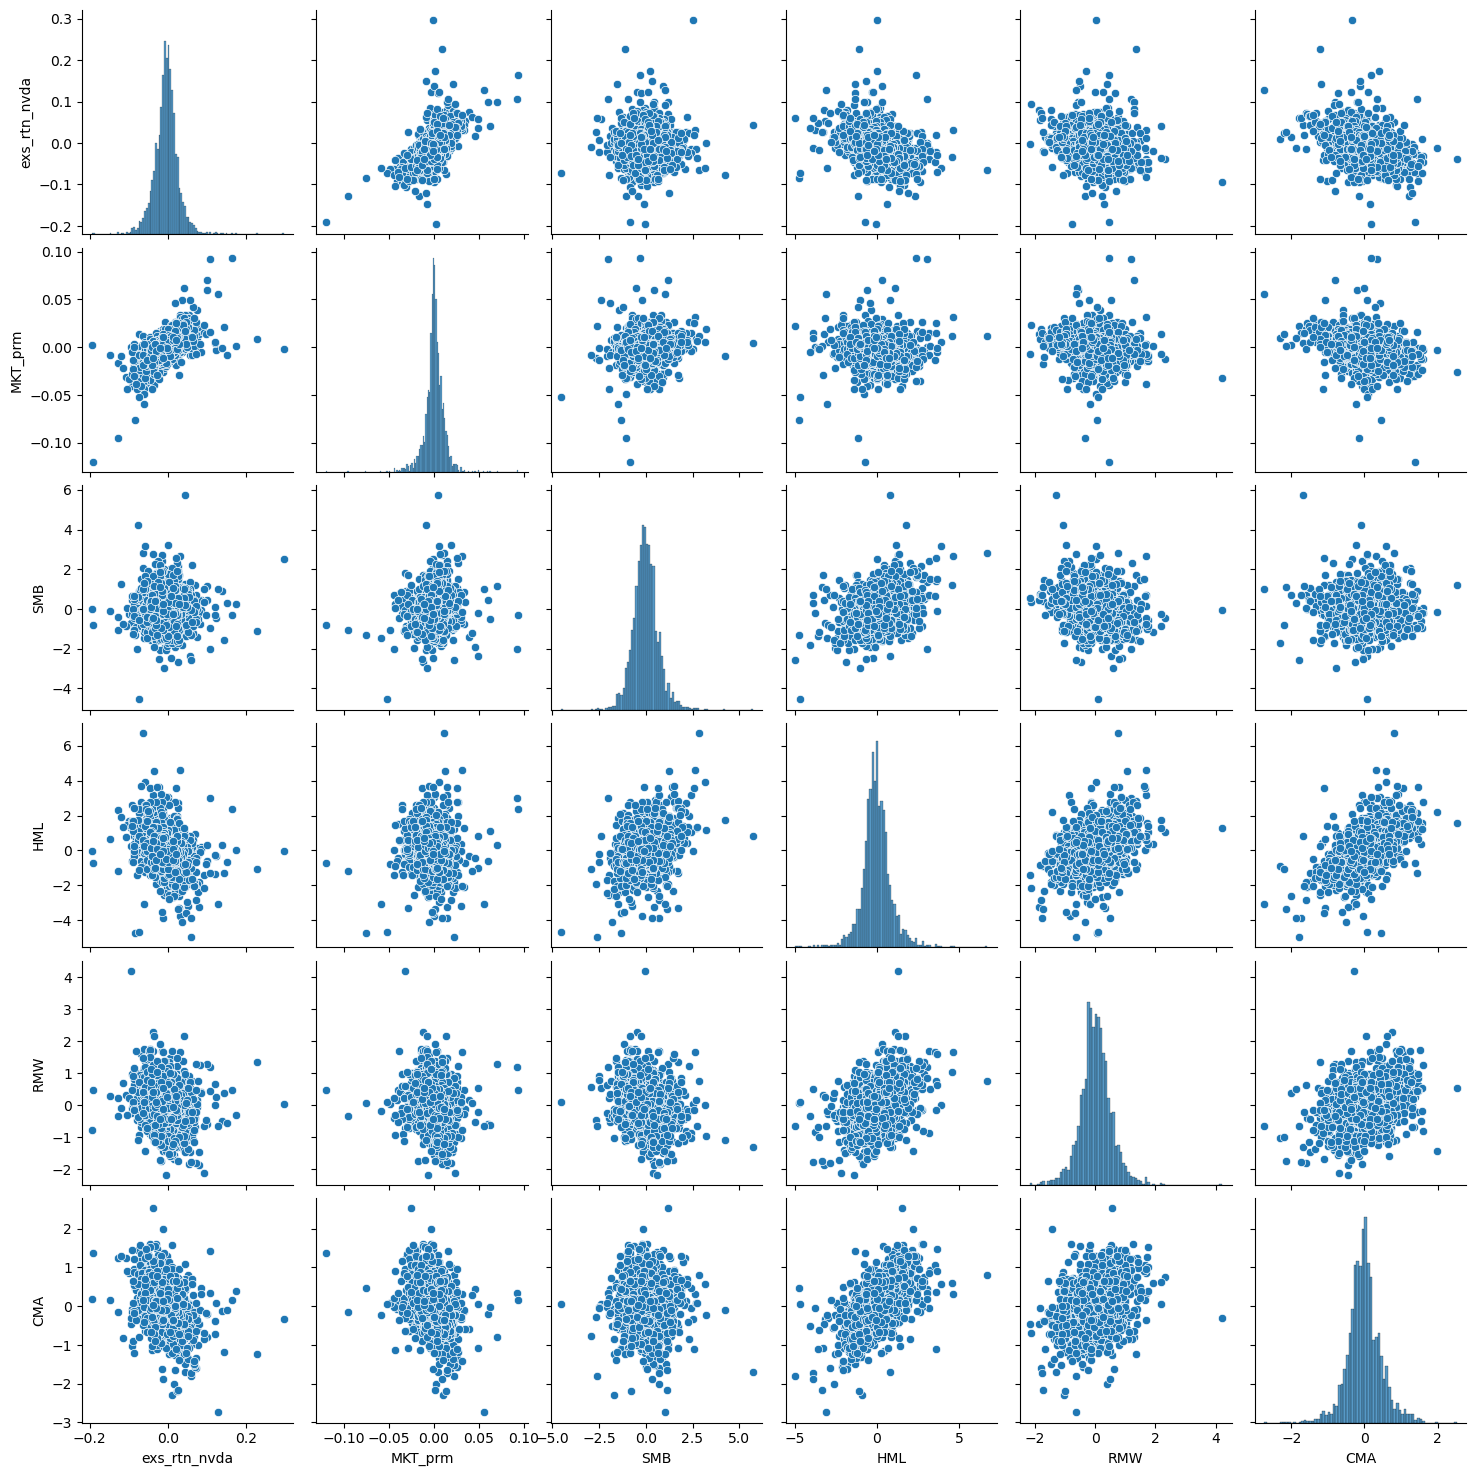

In [15]:
pairplot_ff = sns.pairplot(Stock_close_FF_fltr)
pairplot_ff

NameError: name 'pairplot_ff' is not defined

## EDA

In [24]:
correlation  = Stock_close_FF_fltr.corr()
correlation

,exs_rtn_nvda,MKT_prm,SMB,HML,RMW,CMA
exs_rtn_nvda,1.000000,0.618596,0.039943,-0.302965,-0.187945,-0.368811
MKT_prm,0.618596,1.000000,0.127140,-0.047083,-0.134328,-0.266230
SMB,0.039943,0.127140,1.000000,0.275170,-0.277576,0.029243
HML,-0.302965,-0.047083,0.275170,1.000000,0.321292,0.579948
RMW,-0.187945,-0.134328,-0.277576,0.321292,1.000000,0.276740
CMA,-0.368811,-0.266230,0.029243,0.579948,0.276740,1.000000


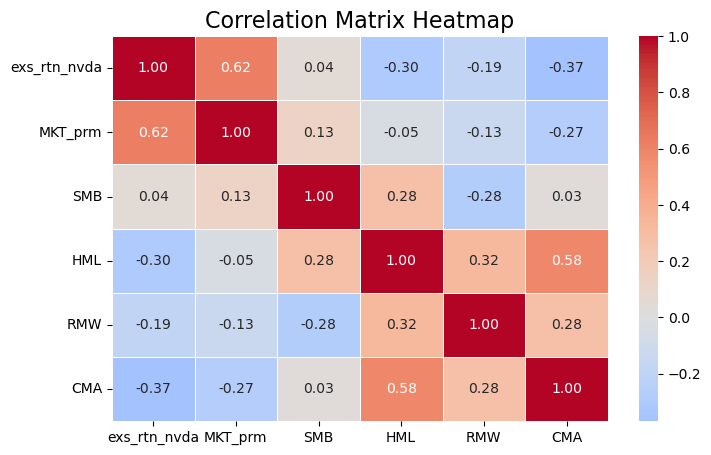

In [107]:
plt.figure(figsize=(8, 5))

# Draw the heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")

# # Add a title
plt.title('Correlation Matrix Heatmap', fontsize=16)

# Show the plot
plt.show()

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

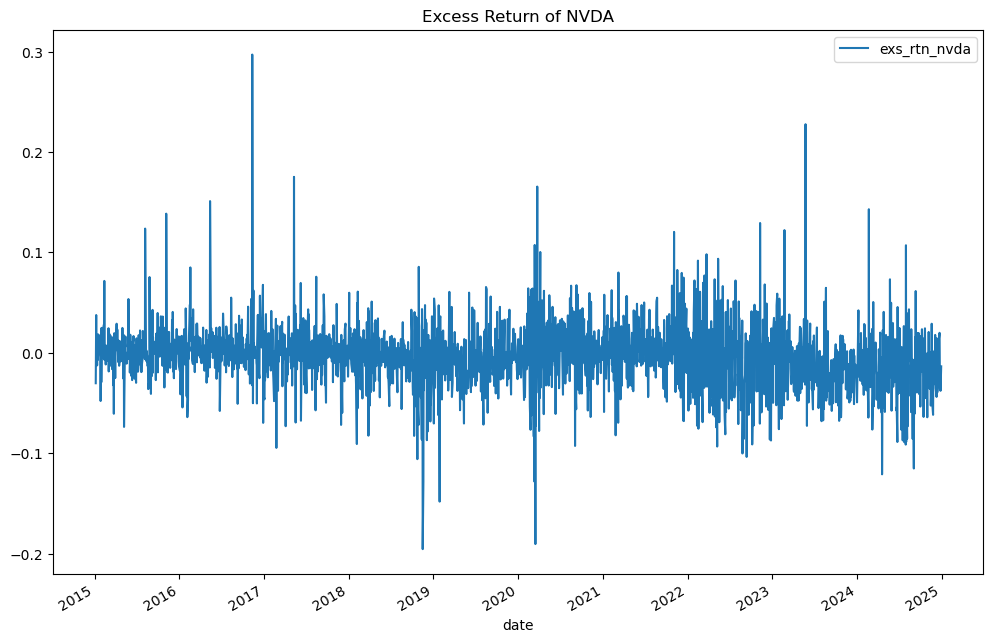

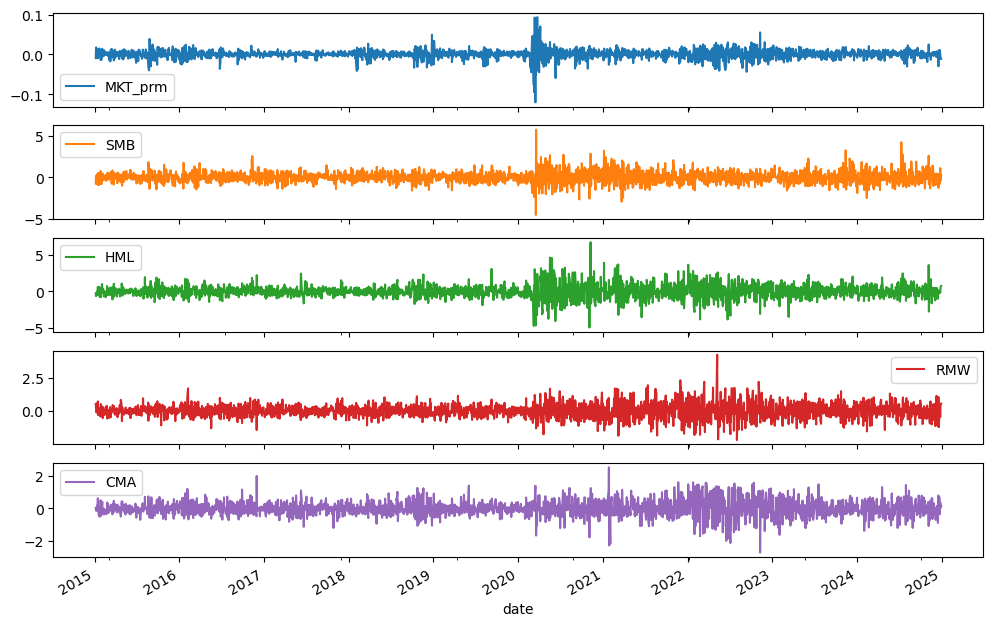

In [78]:
Stock_close_FF_fltr.plot(y='exs_rtn_nvda', title='Excess Return of NVDA',figsize=(12, 8))
Stock_close_FF_fltr[['MKT_prm', 'SMB', 'HML', 'RMW', 'CMA']].plot(subplots=True, figsize=(12, 8))


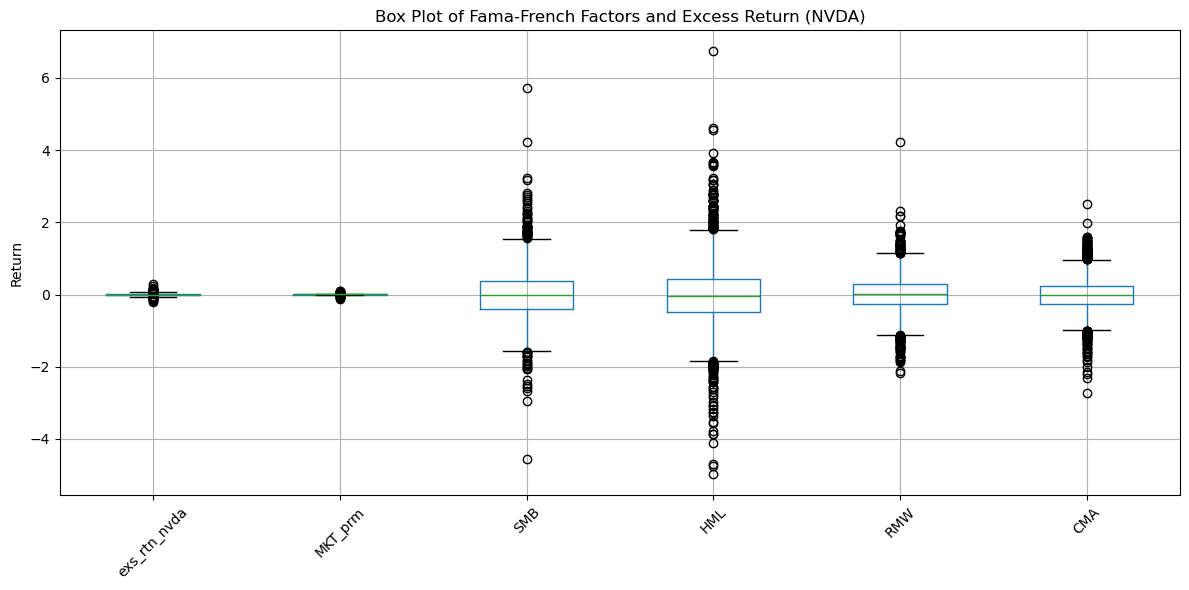

In [28]:
import matplotlib.pyplot as plt

# Assuming you already have Stock_close_FF_fltr loaded
plt.figure(figsize=(12, 6))
Stock_close_FF_fltr.boxplot()
plt.title("Box Plot of Fama-French Factors and Excess Return (NVDA)")
plt.ylabel("Return")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


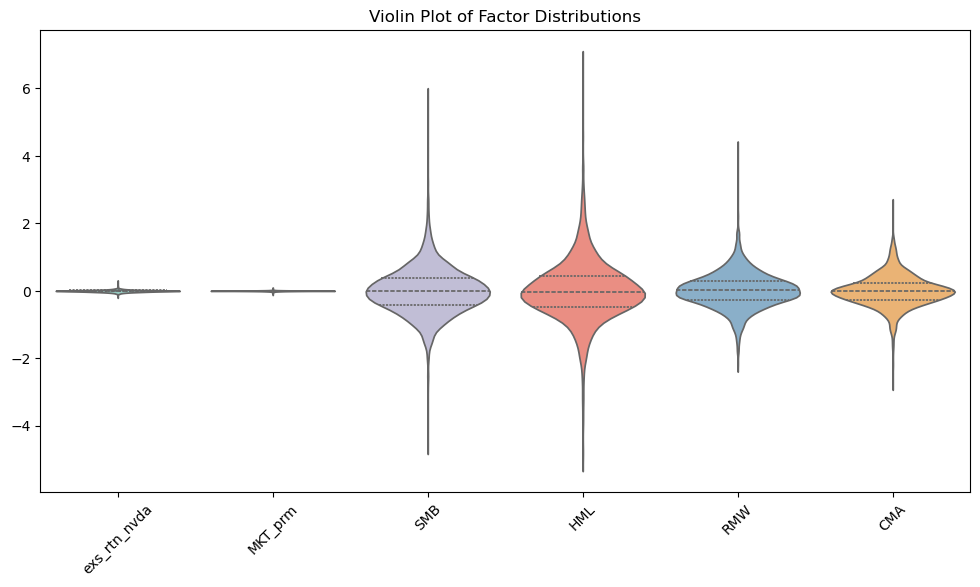

In [26]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=Stock_close_FF_fltr, palette="Set3", inner="quartile")
plt.title("Violin Plot of Factor Distributions")
plt.xticks(rotation=45)
plt.show()


## Distribution Plot

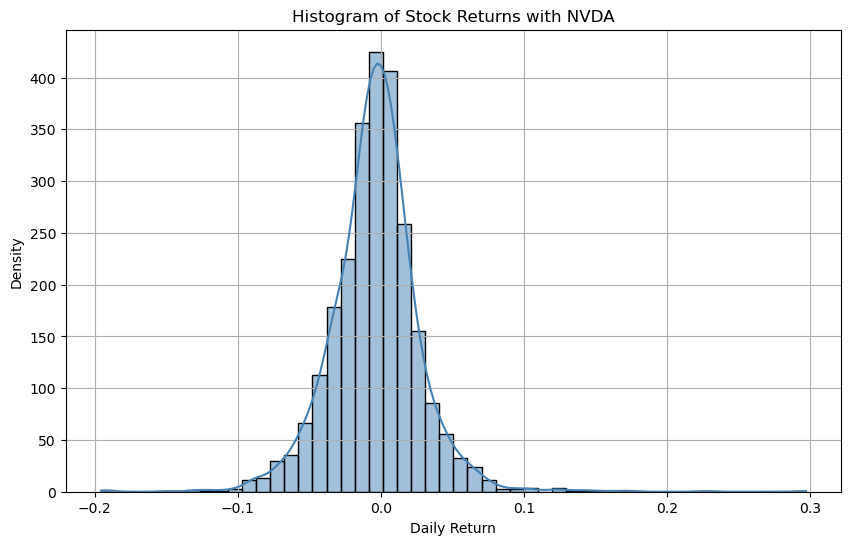

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop missing values if any


plt.figure(figsize=(10, 6))
sns.histplot(Stock_close_FF_fltr['exs_rtn_nvda'], bins=50, kde=True, color='steelblue')
plt.title('Histogram of Stock Returns with NVDA')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [17]:
Stock_close_FF_fltr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2513 entries, 2015-01-06 to 2024-12-30
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   exs_rtn_nvda  2513 non-null   float64
 1   MKT_prm       2513 non-null   float64
 2   SMB           2513 non-null   float64
 3   HML           2513 non-null   float64
 4   RMW           2513 non-null   float64
 5   CMA           2513 non-null   float64
dtypes: float64(6)
memory usage: 137.4 KB


# 1. Regression model

In [42]:
# # Fit the regression model
reg_nvda_ff = smf.ols('exs_rtn_nvda ~ MKT_prm+SMB+HML+RMW+CMA', data=Stock_close_FF_fltr).fit()

# # Print the summary
print(reg_nvda_ff.summary())

                            OLS Regression Results                            
Dep. Variable:           exs_rtn_nvda   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     431.9
Date:                Sun, 20 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:50:35   Log-Likelihood:                 5912.1
No. Observations:                2513   AIC:                        -1.181e+04
Df Residuals:                    2507   BIC:                        -1.178e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0045      0.000     -9.868      0.0

# Calculating the expected return

In [43]:
# Extracting coefficients (alpha and betas for each factor)
alpha_ff = reg_nvda_ff.params['Intercept']
beta_market = reg_nvda_ff.params['MKT_prm']
beta_smb = reg_nvda_ff.params['SMB']
beta_hml = reg_nvda_ff.params['HML']
beta_rmw = reg_nvda_ff.params['RMW']
beta_cma = reg_nvda_ff.params['CMA']

# Extract R-squared and Adjusted R-squared
r_squared_ff = reg_nvda_ff.rsquared
adj_r_squared_ff = reg_nvda_ff.rsquared_adj

# Print results
print(f"Alpha (α): {alpha_ff}")
print(f"Beta (Market) (β_MKT): {beta_market}")
print(f"Beta (SMB) (β_SMB): {beta_smb}")
print(f"Beta (HML) (β_HML): {beta_hml}")
print(f"Beta (RMW) (β_RMW): {beta_rmw}")
print(f"Beta (CMA) (β_CMA): {beta_cma}")
print(f"R-squared: {r_squared_ff}")
print(f"Adjusted R-squared: {adj_r_squared_ff}")

# # Optional: Compute expected return based on a given market premium
# market_premium_value_ff = Stock_close_FF_fltr['MKT_prm'].mean() # Example market premium (6%)
# smb_value = Stock_close_FF_fltr['SMB'].mean() # Example SMB factor
# hml_value = Stock_close_FF_fltr['HML'].mean() # Example HML factor
# rmw_value = Stock_close_FF_fltr['RMW'].mean()  # Example RMW factor
# cma_value = Stock_close_FF_fltr['CMA'].mean()  # Example CMA factor

# # Compute expected return using the Fama-French 5-factor model equation
# expected_return_ff = (alpha_ff + 
#                       beta_market * market_premium_value_ff + 
#                       beta_smb * smb_value + 
#                       beta_hml * hml_value + 
#                       beta_rmw * rmw_value+
#                       beta_cma * cma_value)

# print(f"Expected Return (FF5): {expected_return_ff:.4f}")

Alpha (α): -0.00454224296095185
Beta (Market) (β_MKT): 1.6305115444702063
Beta (SMB) (β_SMB): 0.0015337657193761635
Beta (HML) (β_HML): -0.00840149875765791
Beta (RMW) (β_RMW): -0.00014070219768724107
Beta (CMA) (β_CMA): -0.004961975193234835
R-squared: 0.46274419864928784
Adjusted R-squared: 0.4616726872784248


In [44]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Actual and predicted values
y_actual = Stock_close_FF_fltr['exs_rtn_nvda']
y_pred_ff = reg_nvda_ff.fittedvalues

# Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse_ff = mean_squared_error(y_actual, y_pred_ff)
rmse_ff = np.sqrt(mse_ff)

print(f"Fama-French MSE: {mse_ff:.6f}")
print(f"Fama-French RMSE: {rmse_ff:.6f}")

Fama-French MSE: 0.000530
Fama-French RMSE: 0.023017


 Conclusion
- The Fama-French 5-Factor model performs significantly better than the CAPM in explaining Nvidia’s excess returns, with  R² value (0.569 vs 0.484).

- The prediction accuracy is stronger in the Fama-French model as reflected by a lower RMSE (0.02289 vs 0.03307) and MSE.

- The negative alpha in both models suggests Nvidia slightly underperforms relative to what the model predicts.

- Factors HML and CMA show statistical significance (p < 0.05), indicating value and investment factors contribute meaningfully to return movements. SMB and RMW are not significant, suggesting they may not influence Nvidia's excess returns much in 2024.

Degree 1 - Mean CV MSE: 0.000542
Degree 2 - Mean CV MSE: 0.000559
Degree 3 - Mean CV MSE: 0.000595
Degree 4 - Mean CV MSE: 0.007551
Degree 5 - Mean CV MSE: 0.145792


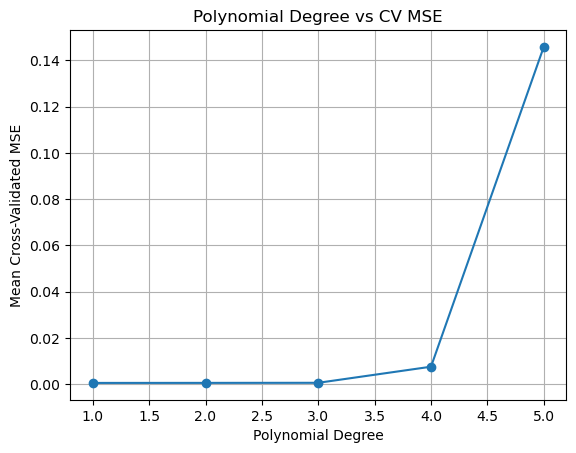


 Best Polynomial Degree: 1


In [45]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Define X and y
X = Stock_close_FF_fltr[['MKT_prm', 'SMB', 'HML', 'RMW', 'CMA']]
y = Stock_close_FF_fltr['exs_rtn_nvda']

# Range of degrees to test
degrees = range(1, 6)
mean_mse_scores = []

# Loop through each degree
for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    mse_scores = cross_val_score(model, X_poly, y, 
                                 scoring='neg_mean_squared_error', cv=30)
    
    mean_mse = -np.mean(mse_scores)  # Convert to positive MSE
    mean_mse_scores.append(mean_mse)
    print(f"Degree {degree} - Mean CV MSE: {mean_mse:.6f}")

# Plot the results
plt.plot(degrees, mean_mse_scores, marker='o')
plt.title("Polynomial Degree vs CV MSE")
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Cross-Validated MSE")
plt.grid(True)
plt.show()

# Best degree
best_degree = degrees[np.argmin(mean_mse_scores)]
print(f"\n Best Polynomial Degree: {best_degree}")


In [47]:
# Step 1: Ensure data is sorted by date
Stock_close_FF_fltr = Stock_close_FF_fltr.sort_index()

# Step 2: Define features and target
X = Stock_close_FF_fltr[['MKT_prm', 'SMB', 'HML', 'RMW', 'CMA']]
y = Stock_close_FF_fltr['exs_rtn_nvda']

# Step 3: Time-aware split (80% train, 20% test)
split_index = int(len(X) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]


In [48]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Use the same formula, but fit on training data only
formula = 'exs_rtn_nvda ~ MKT_prm + SMB + HML + RMW + CMA'
reg_nvda_ff_train = smf.ols(formula=formula, data=Stock_close_FF_fltr.iloc[:split_index]).fit()

# Step 2: Predict on test set manually using model.predict
X_test_sm = sm.add_constant(X_test)  # statsmodels expects intercept
y_pred_ff = reg_nvda_ff_train.predict(X_test_sm)

# Step 3: Evaluate performance
mse = mean_squared_error(y_test, y_pred_ff)
r2 = r2_score(y_test, y_pred_ff)
n = len(y_test)
p = X_test.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Step 4: Print results
print(" Fama-French OLS (Test Data):")
print(f"MSE: {mse}")
print(f"R²: {r2}")
print(f"Adjusted R²: {adj_r2}")


 Fama-French OLS (Test Data):
MSE: 0.0008508598942683694
R²: 0.1651409812694402
Adjusted R²: 0.15674199717758353


## Time series chart for Actual vs Predicted

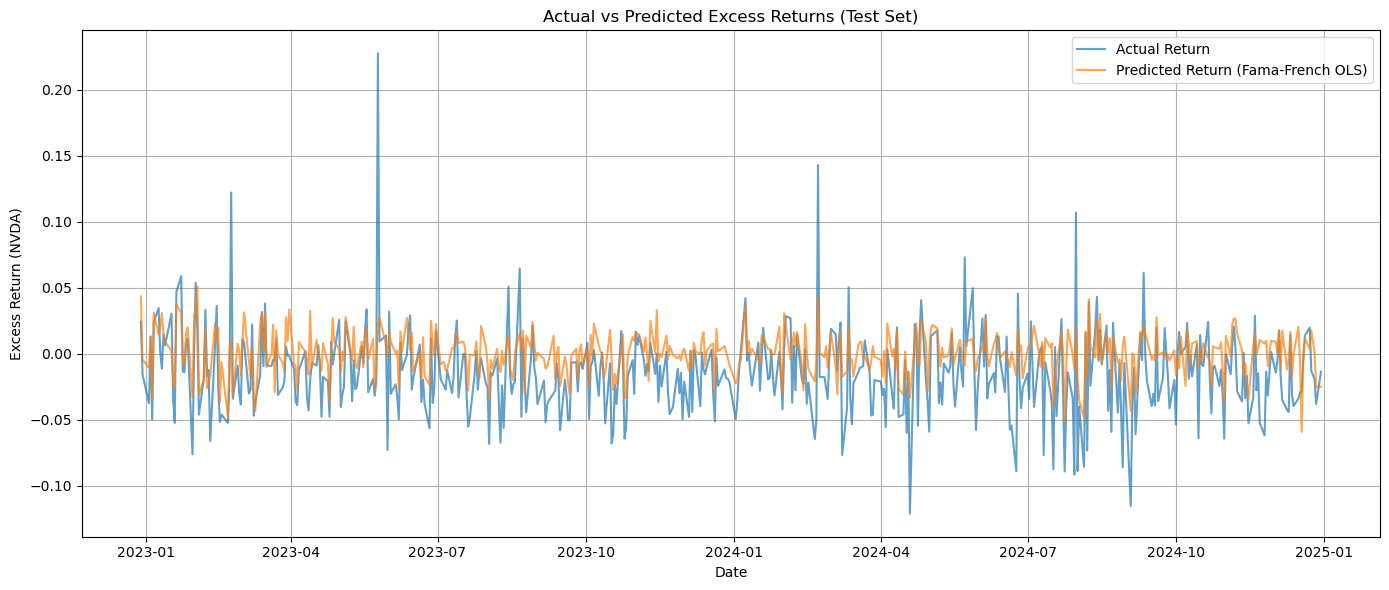

In [49]:
import matplotlib.pyplot as plt

# Make sure the test set index (date) is preserved
y_test_plot = y_test.copy()
y_pred_plot = pd.Series(y_pred_ff, index=y_test.index)

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test_plot.index, y_test_plot, label='Actual Return', alpha=0.7)
plt.plot(y_pred_plot.index, y_pred_plot, label='Predicted Return (Fama-French OLS)', alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Excess Return (NVDA)")
plt.title("Actual vs Predicted Excess Returns (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
dfn = pd.read_excel('Comapny_data.xlsx')
dfn.head()

,Fiscal Year,Revenue (USD),Operating Income (USD),Net Income (USD)
0,2015,4.68,0.759,0.631
1,2016,5.01,0.747,0.614
2,2017,6.91,1.930,1.670
3,2018,9.71,3.210,3.050
4,2019,11.72,3.800,4.140


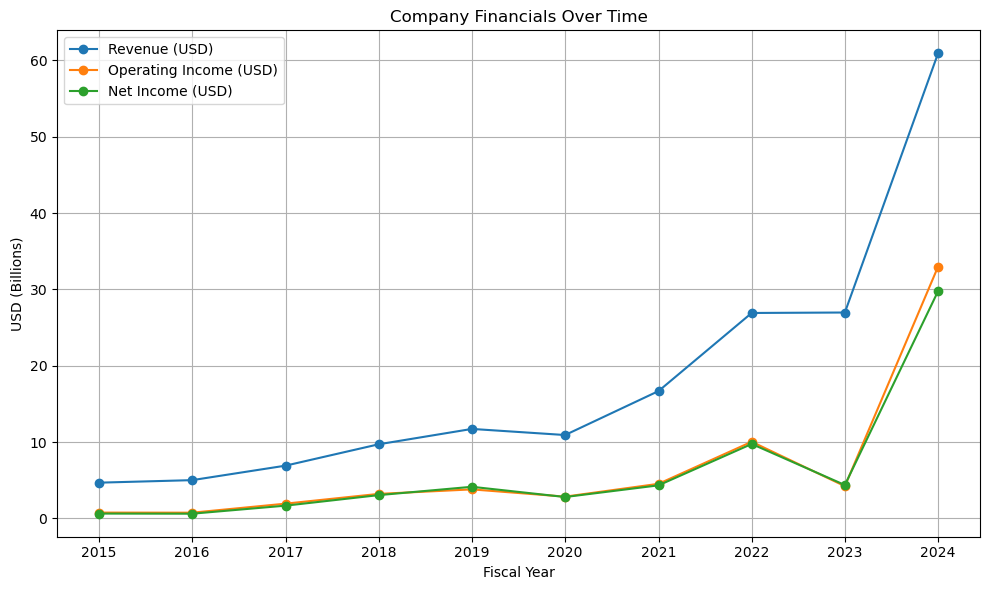

In [23]:


# Convert 'Fiscal Year' to datetime (we'll assume it's Jan 1 of each year)
dfn['Fiscal Year'] = pd.to_datetime(dfn['Fiscal Year'], format='%Y')

# Set it as index (optional but good for time series plotting)
dfn.set_index('Fiscal Year', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(dfn.index, dfn['Revenue (USD)'], label='Revenue (USD)', marker='o')
plt.plot(dfn.index, dfn['Operating Income (USD)'], label='Operating Income (USD)', marker='o')
plt.plot(dfn.index, dfn['Net Income (USD)'], label='Net Income (USD)', marker='o')

plt.title('Company Financials Over Time')
plt.xlabel('Fiscal Year')
plt.ylabel('USD (Billions)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## XGBoost

In [50]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [51]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
grid = GridSearchCV(xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_

# Step 4: Predict and evaluate
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
n, p = X_test.shape
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Step 5: Output
print("\nXGBoost Fama-French Model (Tuned):")
print(f"Best Params: {grid.best_params_}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"Adjusted R²: {adj_r2}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits

XGBoost Fama-French Model (Tuned):
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
MSE: 0.0008656816931720937
RMSE: 0.029422469188905506
R²: 0.15059791422404245
Adjusted R²: 0.14205262161060217


<Figure size 1000x500 with 0 Axes>

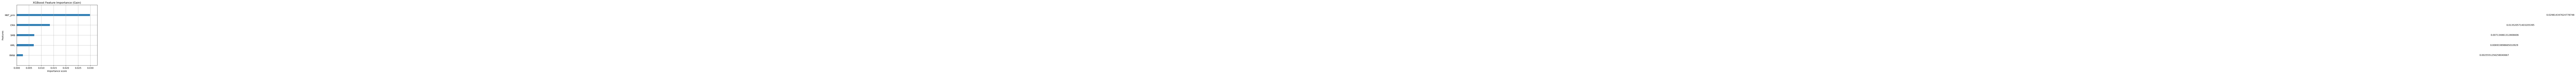

In [24]:
from xgboost import plot_importance


plt.figure(figsize=(10, 5))
plot_importance(best_xgb, max_num_features=10, importance_type='gain')
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()


- This model perform very bas as compared to the regression model

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
# Step 3: Train Random Forest
rf_ff = RandomForestRegressor(n_estimators=100, random_state=42)
rf_ff.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred_rf_ff = rf_ff.predict(X_test)
mse_rf_ff = mean_squared_error(y_test, y_pred_rf_ff)
rmse_rf_ff = mse_rf_ff ** 0.5
r2_rf_ff = r2_score(y_test, y_pred_rf_ff)
n, p = X_test.shape
adj_r2_rf_ff = 1 - (1 - r2_rf_ff) * (n - 1) / (n - p - 1)

# Step 5: Output
print("\n📊 Random Forest (Fama-French Model):")
print(f"MSE: {mse_rf_ff}")
print(f"RMSE: {rmse_rf_ff}")
print(f"R²: {r2_rf_ff}")
print(f"Adjusted R²: {adj_r2_rf_ff}")


📊 Random Forest (Fama-French Model):
MSE: 0.0008803271026931582
RMSE: 0.029670306750911056
R²: 0.1362279194645919
Adjusted R²: 0.12753805949944697
